In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/TensorFlowCourses/labeled_data.csv')
print(df.head())


   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/TensorFlowCourses/labeled_data.csv')
df = df[['class', 'tweet']]
print(df.head())


   class                                              tweet
0      2  !!! RT @mayasolovely: As a woman you shouldn't...
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
import pandas as pd
import re
def preprocess_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    tweet = tweet.lower()
    return tweet
df['processed_tweet'] = df['tweet'].apply(preprocess_tweet)
print(df.head())

   class                                              tweet  \
0      2  !!! RT @mayasolovely: As a woman you shouldn't...   
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                     processed_tweet  
0   rt  as a woman you shouldnt complain about cl...  
1   rt  boy dats coldtyga dwn bad for cuffin dat ...  
2   rt  dawg rt  you ever fuck a bitch and she st...  
3                        rt   she look like a tranny  
4   rt  the shit you hear about me might be true ...  


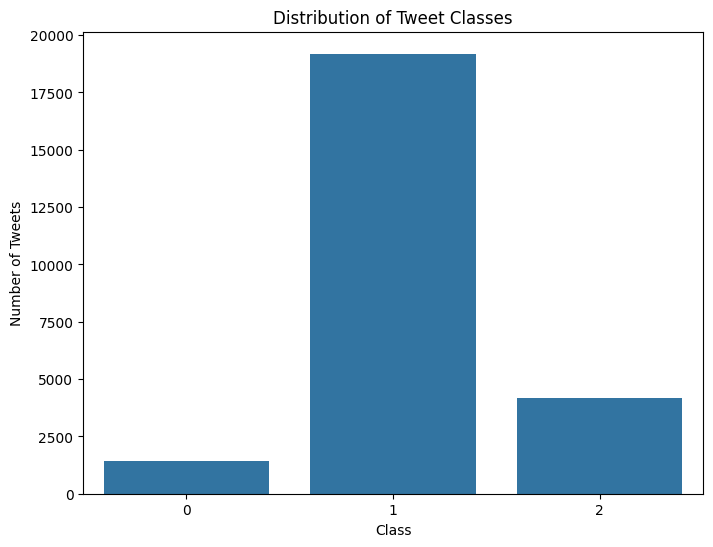

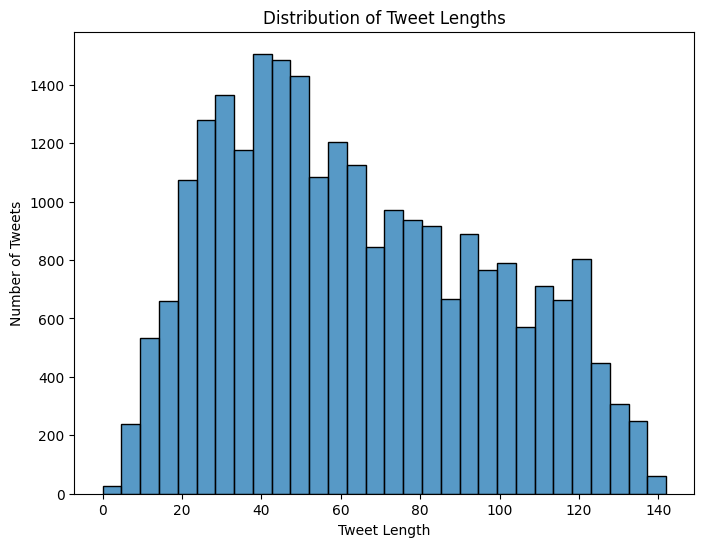

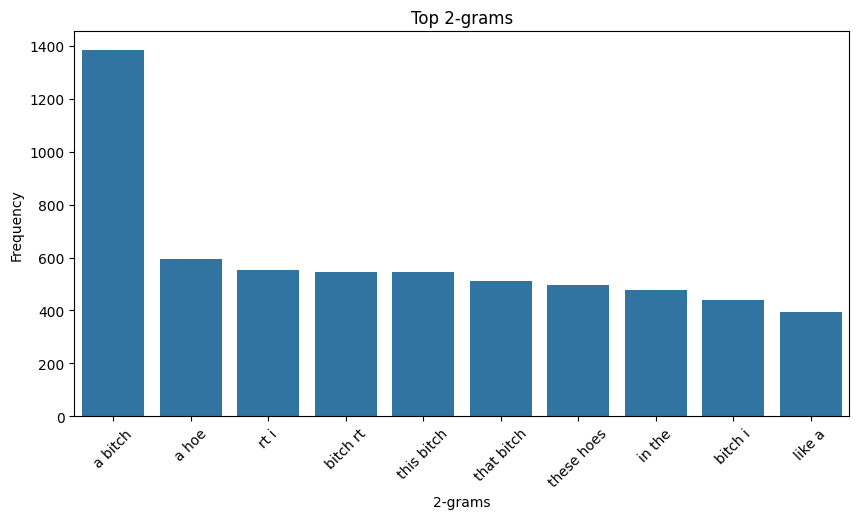

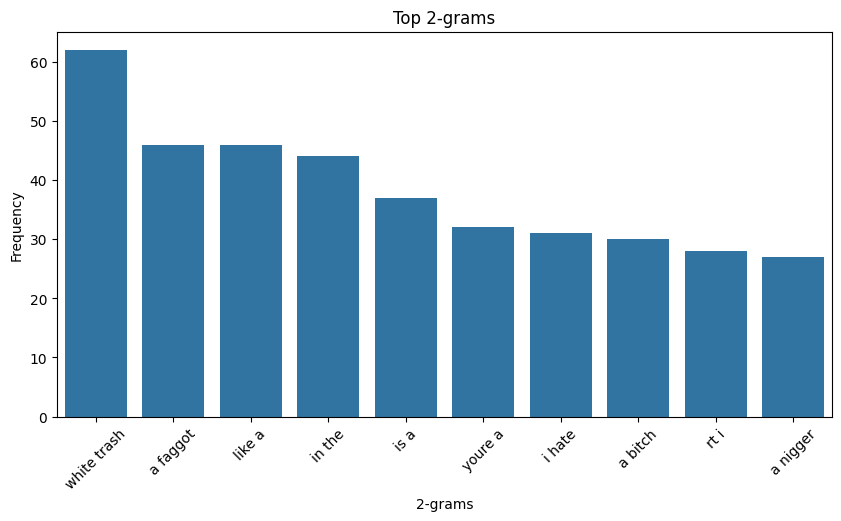

In [9]:

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
text = " ".join(df['processed_tweet'].astype(str))
wordcloud = WordCloud().generate(text)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df)
plt.title('Distribution of Tweet Classes')
plt.xlabel('Class')
plt.ylabel('Number of Tweets')
plt.show()
df['tweet_length'] = df['processed_tweet'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['tweet_length'], bins=30)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.show()
from nltk import ngrams
from collections import Counter

def plot_top_ngrams(text, n=2):
    tokens = text.split()
    ngram_counts = Counter(ngrams(tokens, n))
    top_ngrams = ngram_counts.most_common(10)
    x, y = zip(*top_ngrams)
    x = [" ".join(i) for i in x]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=x, y=y)
    plt.title(f'Top {n}-grams')
    plt.xlabel(f'{n}-grams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

positive_text = " ".join(df[df['class'] == 1]['processed_tweet'].astype(str))
negative_text = " ".join(df[df['class'] == 0]['processed_tweet'].astype(str))

plot_top_ngrams(positive_text)
plot_top_ngrams(negative_text)



In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_recall_curve, roc_curve, auc
)

X = df['processed_tweet']
y = df['class']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (17348,) (17348,)
Validation data shape: (3717,) (3717,)
Test data shape: (3718,) (3718,)


In [18]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 64, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [34]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_padded, y_train, epochs=100, validation_data=(X_val_padded, y_val), verbose=1)

Epoch 1/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9168 - loss: 0.2311 - val_accuracy: 0.8816 - val_loss: 0.3373
Epoch 2/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9287 - loss: 0.2048 - val_accuracy: 0.8862 - val_loss: 0.3165
Epoch 3/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9358 - loss: 0.1886 - val_accuracy: 0.8838 - val_loss: 0.3572
Epoch 4/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9362 - loss: 0.1843 - val_accuracy: 0.8927 - val_loss: 0.3393
Epoch 5/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9406 - loss: 0.1680 - val_accuracy: 0.8918 - val_loss: 0.3128
Epoch 6/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9404 - loss: 0.1650 - val_accuracy: 0.8674 - val_loss: 0.4237
Epoch 7/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9481 - loss: 0.1541 - val_accuracy: 0.8921 - val_loss: 0.3325
Epoch 8/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9482 - loss: 0.1455 - val_

In [35]:
from tensorflow.keras.utils import to_categorical
predictions = model.predict(X_test_padded)
predicted_classes = np.argmax(predictions, axis=1)
num_classes = predictions.shape[1]
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)



117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


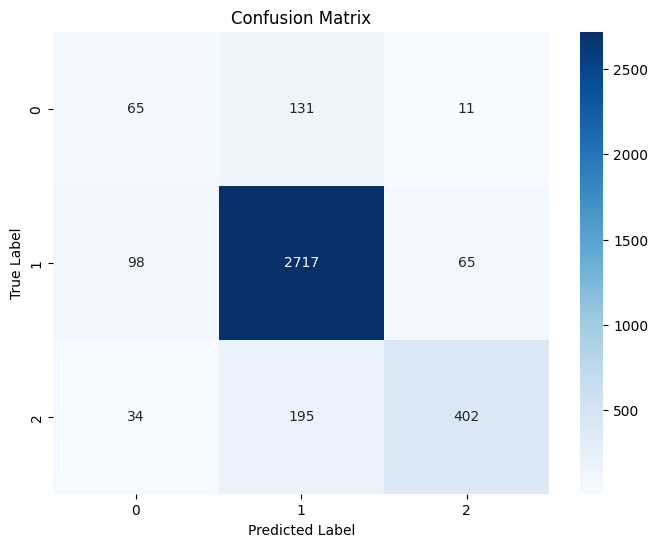

In [36]:
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [37]:
report = classification_report(y_test, predicted_classes)
print("Classification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.31      0.32       207
           1       0.89      0.94      0.92      2880
           2       0.84      0.64      0.72       631

    accuracy                           0.86      3718
   macro avg       0.69      0.63      0.65      3718
weighted avg       0.85      0.86      0.85      3718



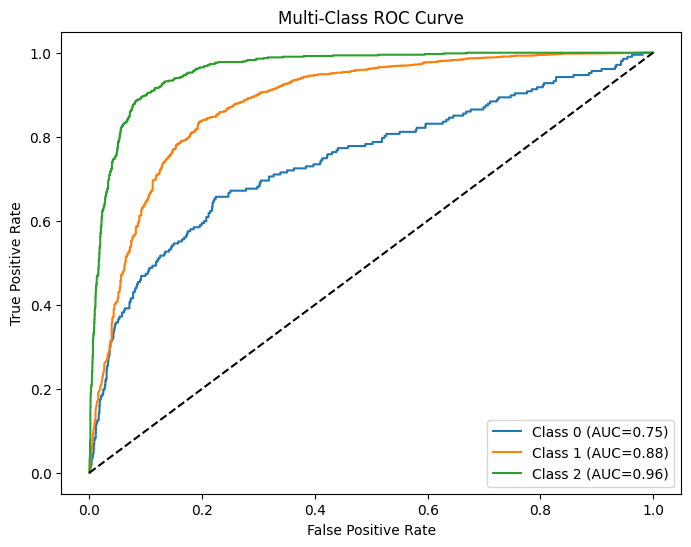

In [38]:
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.show()

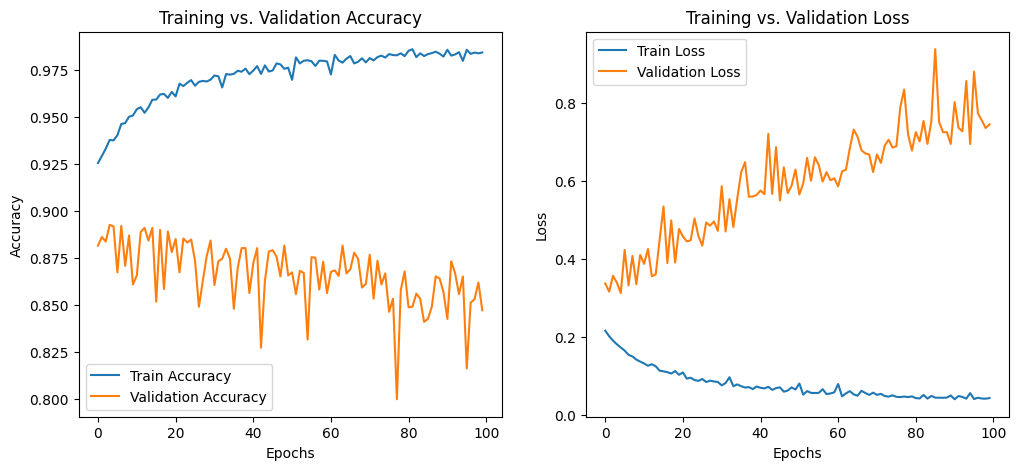

In [39]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

plt.show()



In [40]:
predictions = model.predict(X_test_padded)
predicted_classes = np.argmax(predictions, axis=1)
for i in range(5):
    print(f"Tweet: {X_test.iloc[i]}")
    print(f"Predicted class: {predicted_classes[i]}")
    print(f"Actual class: {y_test[i]}")
    print("---")

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Tweet: confusing circumstances seem to get in the way of your high ho more for virgo 
Predicted class: 1
Actual class: 2
---
Tweet: rt  psa big booty hoe with tig ol bitties 
xbox onepancake booty hoe with pancake tits
Predicted class: 1
Actual class: 1
---
Tweet: maybe i shoulda informed my cousin of my social anxiety before taking me to this over crowded bar on the bright side texas has hott bitches
Predicted class: 1
Actual class: 1
---
Tweet: why the fuck are the  throwing batting practice tonight holy shit
Predicted class: 1
Actual class: 1
---
Tweet: you just want some attention hoe
Predicted class: 1
Actual class: 1
---
